## 矢量计算与标量计算的时间比较

In [2]:
%matplotlib inline
import torch
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import random

## 线性回归的从零开始实现

### 生成数据集
设训练数据集样本数为1000，输入个数（特征数）为2， 给定随机生成的批量样本特征$X\in\mathbb{R}^{1000\times2}$  
使用线性回归模型真实权重$w=[2, -3.4]^{T}$和偏差$b=4.2$，以及一个随机噪声项$\epsilon$来生成标签：  
$$y = Xw + b + \epsilon$$

In [3]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2

features = torch.from_numpy(np.random.normal(0, 1, (num_examples, num_inputs)))
labels = true_w[0] * features[:,0] + true_w[1] * features[:, 1] + true_b
labels += torch.from_numpy(np.random.normal(0, 0.01, size=labels.size()))

In [4]:
features[0], labels[0]

(tensor([0.2883, 1.1002], dtype=torch.float64),
 tensor(1.0419, dtype=torch.float64))

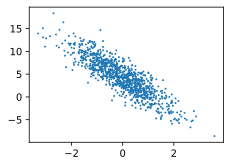

In [5]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
    
    
def set_figsize(figsize = (3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

# from d2lzh_pytorch import *

set_figsize()

plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);  # 加分号只显示图

将上述两个功能函数放在dzlzh_pytorch包里。

### 读取数据

In [6]:
# 小批量随机读取数据样本
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 打乱索引顺序
    random.shuffle(indices)
    
    for i in range(0, num_examples, batch_size):
        # 选取每批样本，注意最后一次可能不足一个batch
        j = torch.LongTensor(indices[i : min(i+batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

In [7]:
batch_size = 10

for x, y in data_iter(batch_size, features, labels):
    print(x, y)
    break

tensor([[-0.5809,  0.1513],
        [-0.7088,  0.3337],
        [-0.9331,  2.6498],
        [-1.0311, -1.5767],
        [-0.2886,  1.1125],
        [-2.1124, -0.0443],
        [-1.0698,  1.0620],
        [ 1.1227,  0.8492],
        [-0.8638,  0.7260],
        [-0.4862,  1.3990]], dtype=torch.float64) tensor([ 2.5246e+00,  1.6487e+00, -6.6808e+00,  7.4887e+00, -1.6317e-01,
         1.4019e-01, -1.5512e+00,  3.5568e+00,  2.5559e-03, -1.5087e+00],
       dtype=torch.float64)


### 初始化模型参数

In [31]:
# 权重初始化为均值是0、标准差为0.01的正态随机数， 偏差初始化为0
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float64)
b = torch.zeros(1, dtype=torch.float64)

模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让他们的requires_grad=True

In [32]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], dtype=torch.float64, requires_grad=True)

### 定义模型

In [22]:
def linreg(X, w, b):
    # 使用 mm 函数做矩阵乘法
    return torch.mm(X, w) + b

### 定义损失函数

用平方损失来定义线性回归的损失函数，实现时，需要将真实值y变形成预测值y_hat的形状

In [23]:
def squared_loss(y_hat, y):
    # 返回的是向量，pytorch里的MSELoss没有除以2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

### 定义优化算法
sgd实现了小批量随机梯度下降算法，它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是⼀个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [24]:
# 小批量随机梯度下降算法
# lr 学习率
def sgd(params, lr, batch_size):
    for param in params:
        # 注意这里更改param时用的是param.data
        param.data -= lr * param.grad / batch_size

### 训练模型

In [33]:
lr = 0.03   # 学习率
num_epochs = 3
net = linreg
loss = squared_loss

# 训练模型一共需要num_epochs个周期
for epoch in range(num_epochs):
    # 每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）
    # x和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        # l是有关小批量X和y的损失
        l = loss(net(X, w, b), y).sum()
        # 小批量的损失对模型参数求梯度
        l.backward()
        # 使用小批量随机梯度下降迭代模型参数
        sgd([w, b], lr, batch_size)
    
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
        
    train_1 = loss(net(features, w, b), labels)
    print("epoch %d， loss %f" % (epoch + 1, train_1.mean().item()))

epoch 1， loss 0.029988
epoch 2， loss 0.000110
epoch 3， loss 0.000046


In [34]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9995],
        [-3.3993]], dtype=torch.float64, requires_grad=True)
4.2 
 tensor([4.1996], dtype=torch.float64, requires_grad=True)
